# Check the stabilisation of  WOA09 salinity field in comparing it to it's original version, and convert it into SalPrac instead SA to use it in CREG025.L75 

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import gsw as gsw

%matplotlib inline

In [3]:
! date

Thu Apr 10 11:43:03 CEST 2025


>>> # get the SA first 

>>> # then the CT using the SA and pt

>>>> # UNITS CONVERSION

In [28]:
INDIR="/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/"
ds_inS=xr.open_mfdataset(INDIR+'woa09_SalAbs_monthly_1deg_SA_CMA_drowned_Ex_L75_Stabilise.nc')
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [29]:
# Add the geographical coordinates
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_geo=xr.open_dataset(INDIR+'woa09_temperature_monthly_1deg.nc',decode_times=False)
ds_geo

<xarray.Dataset>
Dimensions:           (lon: 360, lat: 180, depth: 24, time: 12, nv: 2)
Coordinates:
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth             (depth) float32 0.0 10.0 20.0 ... 1.3e+03 1.4e+03 1.5e+03
  * time              (time) float32 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    climatology_bnds  (time, nv) float32 ...
    t_an              (time, depth, lat, lon) float32 ...
    t_mn              (time, depth, lat, lon) float32 ...
    t_dd              (time, depth, lat, lon) float64 ...
    t_ma              (time, depth, lat, lon) float32 ...
    t_sd              (time, depth, lat, lon) float32 ...
    t_se              (time, depth, lat, lon) float32 ...
    t_oa              (time, depth, lat, lon) float32 ...
    t_gp              (time, depth, lat, lon) float64 ...
    crs               int32 ...
Attributes: (12/40)
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         75d70376-540c-4a1f-a0ca-f19f07dd7272
    naming_authority:           gov.noaa.nodc
    Metadata_Convention:        Unidata Dataset Discovery v1.0
    title:                      World Ocean Atlas 09:  Sea Water Temperature ...
    ...                         ...
    time_coverage_end:          2008-12-25
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid

In [30]:
lat=ds_geo.lat
lon=ds_geo.lon
lat2D=np.tile(lat,(lon.size,1)).T
lon2D=np.tile(lon,(lat.size,1))

In [31]:
lat2D.shape

(180, 360)

In [32]:
# Append this geo. to the WOA09 dataset 
ds_inS.coords['lat']=(('lat0','lon0'),lat2D)
ds_inS.coords['lon']=(('lat0','lon0'),lon2D)
#ds_inS.coords['lon']=(('lat0','lon0'),lon2D-180.)
#ds_inT.coords['lat']=(('lat0','lon0'),lat2D)
#ds_inT.coords['lon']=(('lat0','lon0'),lon2D-180.)

In [33]:
# Need also to provide a depth
INDIR="/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/"
ds_4depth=xr.open_mfdataset(INDIR+'CREG12.L75-REF06_init_gridT.nc')
depth=ds_4depth['deptht']
depth.shape

(75,)

In [34]:
# Prepare this 1D field to be duplicated 
z2dt=np.reshape(depth.values,(75,1,1))
z2dt.shape
#zplt = np.repeat(z2dt,12,axis=0)
#zplt.shape

(75, 1, 1)

In [35]:
# Duplicate this depth to fit the T/S on a global grid
depth3D=np.tile(z2dt,(1,180,360))
depth3D.shape

(75, 180, 360)

In [36]:
ds_inS.coords['depth']=(('z'),depth.data)
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [37]:
# Define a pressure from depth
pressure=gsw.p_from_z(-depth3D,lat2D)
pressure.shape

(75, 180, 360)

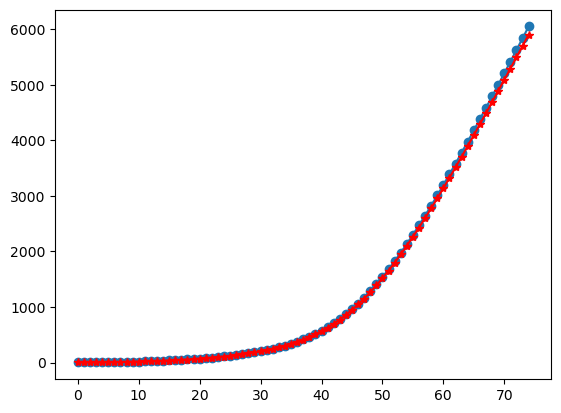

In [19]:
plt.plot(pressure[:,10,10],'-o')
plt.plot(depth3D[:,10,10],'-*',color='r')

# Back to pratical salinity

In [38]:
# Apply the conversion
ds_SP=gsw.conversions.SP_from_SA(ds_inS['SA'],pressure,ds_inS['lon'],ds_inS['lat'] )
ds_SP.shape


(12, 75, 180, 360)

In [39]:
ds_inS['s_an']=(('time_counter','z','lat0','lon0'),ds_SP.data)

In [40]:
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    s_an     (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [41]:
ds_PSinit=xr.open_mfdataset(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_drowned_Ex_L75.nc')
ds_PSinit.coords['lat']=(('lat0','lon0'),lat2D)
ds_PSinit.coords['lon']=(('lat0','lon0'),lon2D)
ds_PSinit.coords['depth']=(('z'),depth.data)
ds_PSinit


<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    s_an     (time_counter, z, lat0, lon0) float32 dask.array<chunksize=(1, 38, 90, 180), meta=np.ndarray>
Attributes:
    description:  WOA09 field for the 1degx1deg grid with duplicated levelswi...

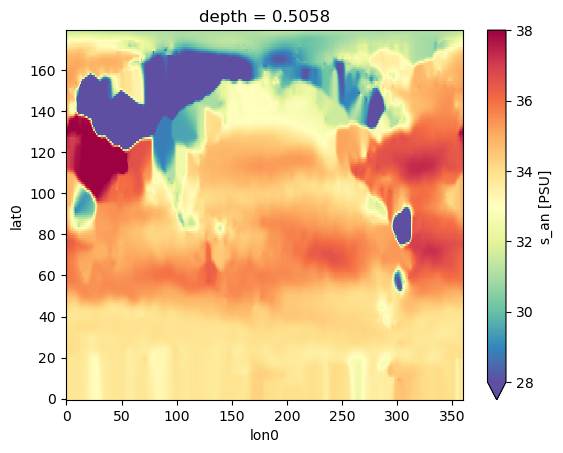

In [34]:
ds_PSinit.s_an.isel(time_counter=0,z=0).plot(vmin=28.,vmax=38.,cmap='Spectral_r')

Text(0.5, 1.0, 'New-init at depth 412.0 m')

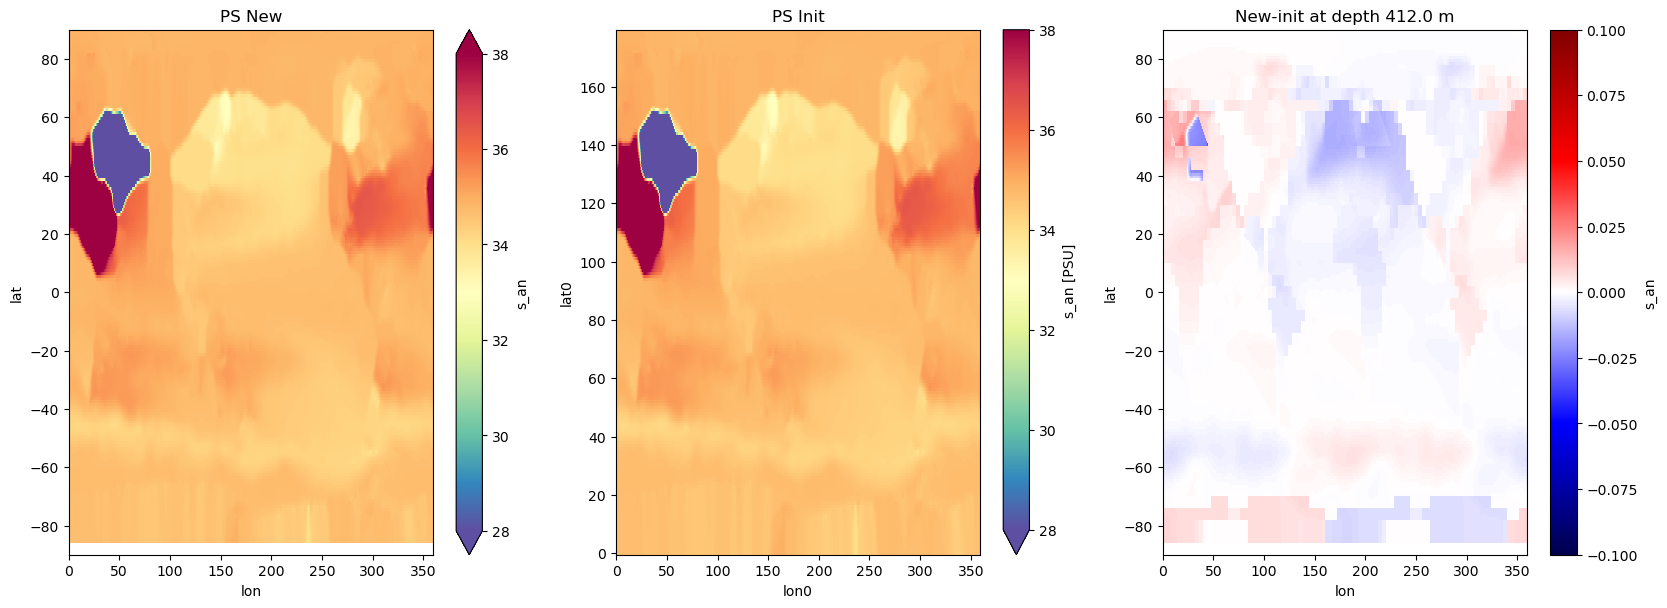

In [20]:
# Control 2D the final result
it=0 ; iz=37 

plt.figure(figsize=(20,15))
plt.subplot(231)
ds_inS['s_an'].isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon',y='lat')
plt.title('PS New')

plt.subplot(232)
ds_PSinit['s_an'].isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon0',y='lat0')
#ds_SA.isel(time_counter=it,z=iz).plot(vmin=28.,vmax=38.,cmap='Spectral_r',x='lon',y='lat')
plt.title('PS Init')

plt.subplot(233)
(ds_inS['s_an'].isel(time_counter=it,z=iz)-ds_PSinit['s_an'].isel(time_counter=it,z=iz)).\
plot(vmin=-1e-1,vmax=1e-1,cmap='seismic',x='lon',y='lat')
plt.title('New-init at depth '+str(np.round(depth4D[0,iz,0,0]))+' m')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


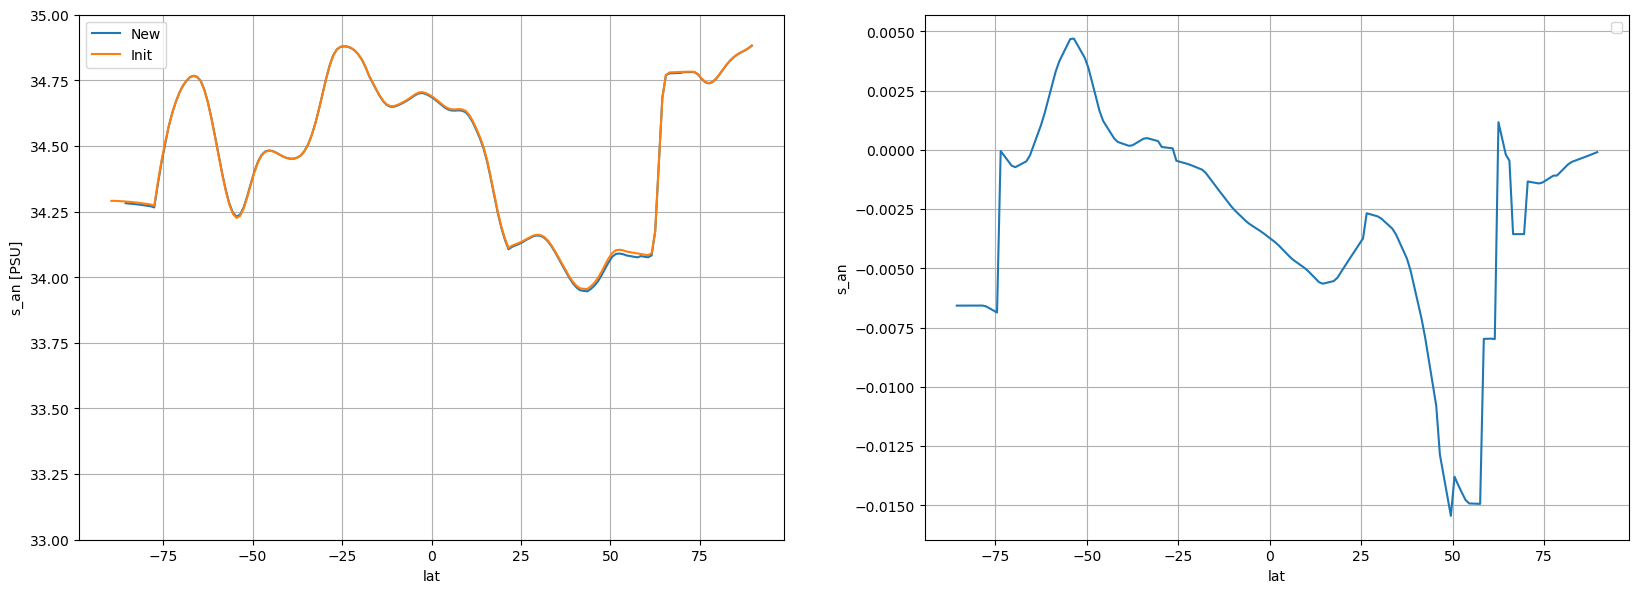

In [25]:
# Control the final result along a given longitude
it=5 ; iz=37 ; ilon=200

plt.figure(figsize=(20,15))
plt.subplot(221)
ds_inS['s_an'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='New',x='lat')
ds_PSinit['s_an'].isel(time_counter=it,z=iz,lon0=ilon).plot(label='Init',x='lat')
#plt.xlim([0,180])
plt.ylim([33,35])
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_inS['s_an'].isel(time_counter=it,z=iz,lon0=ilon)-ds_PSinit['s_an'].\
 isel(time_counter=it,z=iz,lon0=ilon)).plot(x='lat')
#plt.xlim([0,180])
#plt.ylim([30,36])
plt.grid(True)
plt.legend()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


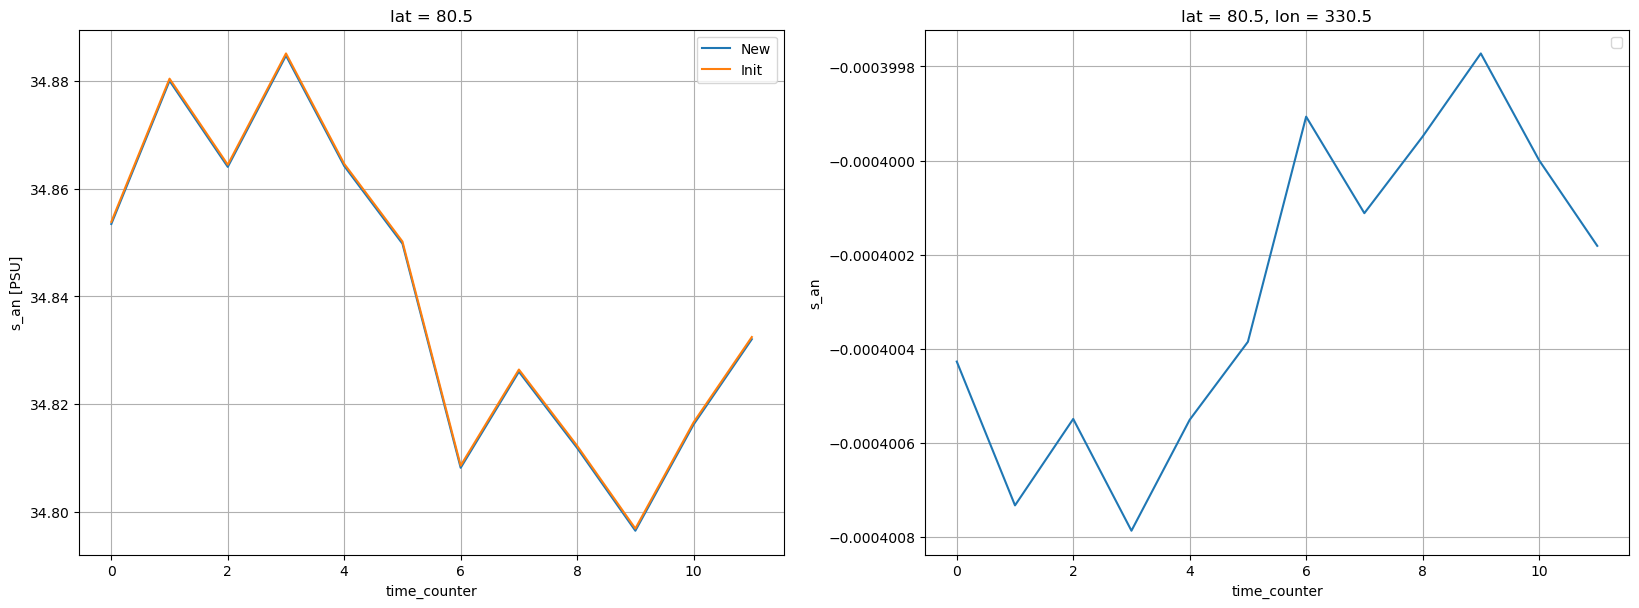

In [21]:
# Control the seasonal cycle 
ilon=330 ; ilat=170 ; iz=37 ;

plt.figure(figsize=(20,15))
plt.subplot(221)
ds_inS['s_an'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='New',x='time_counter')
ds_PSinit['s_an'].isel(z=iz,lon0=ilon,lat0=ilat).plot(label='Init',x='time_counter')
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_inS['s_an'].isel(z=iz,lon0=ilon,lat0=ilat)-ds_PSinit['s_an'].isel(z=iz,lon0=ilon,lat0=ilat)).plot(x='time_counter')
plt.grid(True)
plt.legend()



> # Explore now the vertical profiles 

In [17]:
ds_inS

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    s_an     (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [4]:
# Read WOA09 original salinity
INDIR='/data0/project/drakkar/REFERENCE_DATA/WOA2009/DATA/1degx1deg/'
ds_woa09I=xr.open_dataset(INDIR+'woa09_salinity_monthly_1deg.nc',\
                          drop_variables=['s_mn','s_dd','s_dd','s_ma','s_sd','s_se','s_oa','s_gp'],\
                          decode_times=False)
ds_woa09I

<xarray.Dataset>
Dimensions:           (lon: 360, lat: 180, depth: 24, time: 12, nv: 2)
Coordinates:
  * lon               (lon) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * lat               (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * depth             (depth) float32 0.0 10.0 20.0 ... 1.3e+03 1.4e+03 1.5e+03
  * time              (time) float32 15.0 46.0 75.0 106.0 ... 289.0 320.0 350.0
Dimensions without coordinates: nv
Data variables:
    lat_bnds          (lat, nv) float32 ...
    lon_bnds          (lon, nv) float32 ...
    climatology_bnds  (time, nv) float32 ...
    s_an              (time, depth, lat, lon) float32 ...
    crs               int32 ...
Attributes: (12/40)
    CVS_ID:                     1.0
    Conventions:                CF-1.4
    id:                         592ac385-a915-4d55-8f34-0f85caf22756
    naming_authority:           gov.noaa.nodc
    Metadata_Convention:        Unidata Dataset Discovery v1.0
    title:                      World Ocean Atlas 09:  Sea Water Salinity - m...
    ...                         ...
    time_coverage_end:          2008-12-25
    time_coverage_duration:     P1Y
    time_coverage_resolution:   P1M
    processing_level:           synthesized product
    license:                    This data is free for anyone to use, reuse an...
    cdm_data_type:              Grid

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


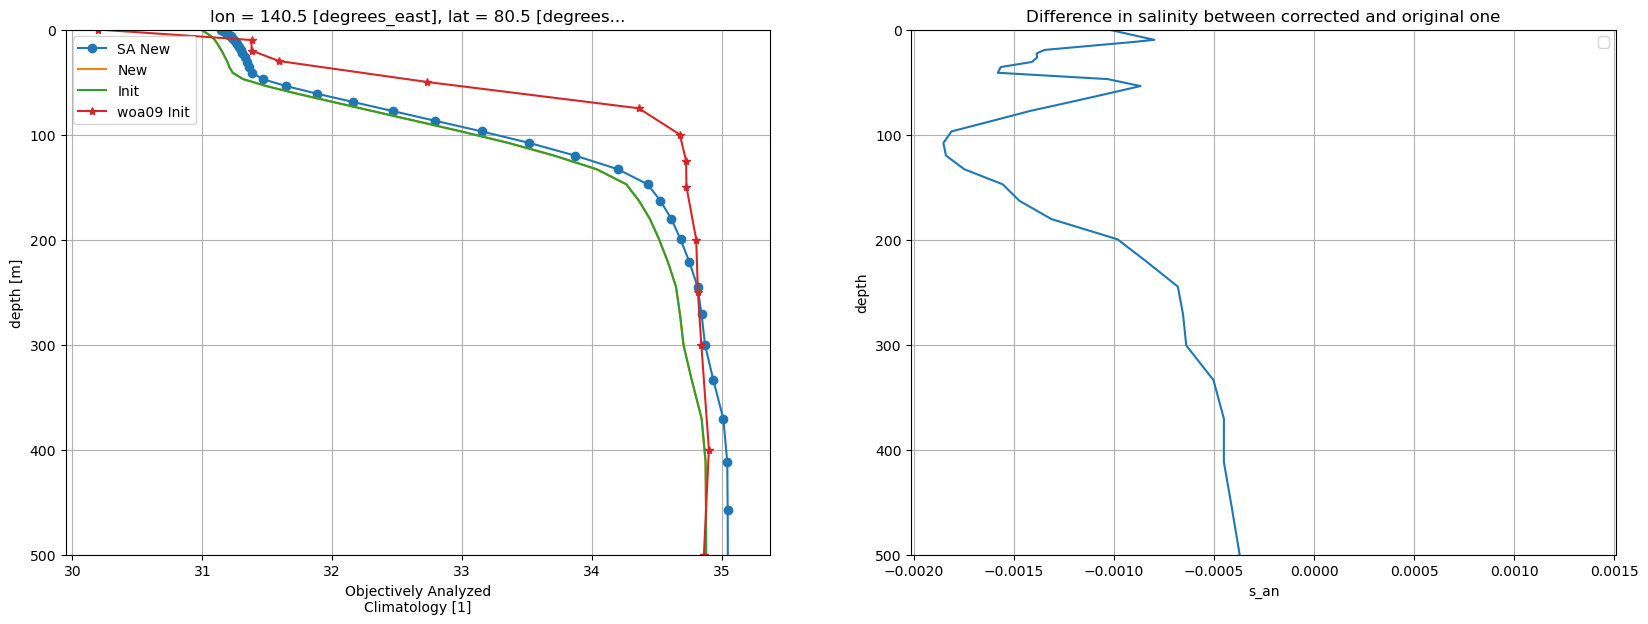

In [27]:
# Control the seasonal cycle 
ilon=320 ; ilat=170 ; iz=37 ;

plt.figure(figsize=(20,15))
plt.subplot(221)
ds_inS['SA'].isel(time_counter=0,lon0=ilon,lat0=ilat).plot(y='depth',yincrease=False,label='SA New',marker='o')
ds_inS['s_an'].isel(time_counter=0,lon0=ilon,lat0=ilat).plot(y='depth',yincrease=False,label='New')
ds_PSinit['s_an'].isel(time_counter=0,lon0=ilon,lat0=ilat).plot(label='Init',y='depth')
ds_woa09I['s_an'].isel(time=0).sel(lat=80.5,lon=140.5).plot(y='depth',yincrease=False,label='woa09 Init',marker='*')
plt.ylim([500,0])
plt.grid(True)
plt.legend()

plt.subplot(222)
(ds_inS['s_an'].isel(time_counter=0,lon0=ilon,lat0=ilat)-ds_PSinit['s_an'].isel(time_counter=0,lon0=ilon,lat0=ilat)).plot(y='depth',yincrease=False)
plt.ylim([500,0])
plt.grid(True)
plt.title('Difference in salinity between corrected and original one')
plt.legend()

In [28]:
print(ds_inS.lat.isel(lon0=ilon,lat0=ilat).values)
print(ds_inS.lon.isel(lon0=ilon,lat0=ilat).values-180.)

80.5
140.5


> # Now compute potential instabilities

In [42]:
INDIR="/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/"
ds_inT=xr.open_dataset(INDIR+'woa09_temperature_monthly_1deg_t_an_CMA_drowned_Ex_L75.nc')
ds_inT

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    t_an     (time_counter, z, lat0, lon0) float32 ...
Attributes:
    description:  WOA09 field for the 1degx1deg grid with duplicated levelswi...

In [43]:
ds_inT['CT']=gsw.conversions.CT_from_pt(ds_inS['SA'],ds_inT['t_an'])

In [44]:
# Compute the Brunt-Vaissalla frequency
DINT_N2,p_imd=gsw.Nsquared(ds_inS['SA'].isel(time_counter=0).values,\
                            ds_inT['CT'].isel(time_counter=0).values,\
                            pressure,axis=0)

In [45]:
ds_WN2=xr.Dataset()
ds_WN2['N2']=(('depth','lat0','lon0'),DINT_N2)
ds_WN2.coords['lat']=ds_inS['lat']
ds_WN2.coords['lon']=ds_inS['lon']
ds_WN2.coords['depth']=ds_inS['depth']

# Build a 2D map to see how many instabilities occur on each water column
num_DINT_N2=np.where(DINT_N2 < 0.,1.,0.)
# Remove the grid points in the a pseudo ML
num_DINT_N2[0:10,:,:]=0. 
num_DINT_N2[50::,:,:]=0. 
ds_WN2['Instab']=(('lat0','lon0'),np.sum(num_DINT_N2,axis=0))
#ds_WN2['Instab']=xr.where(np.isnan(ds_woa09I['s_an'].isel(time=0,depth=0)),np.nan,ds_WN2['Instab'])
    

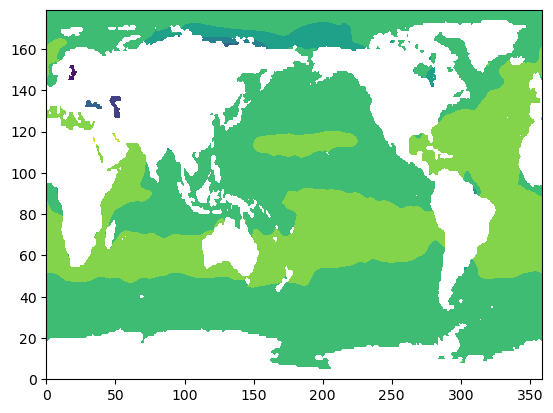

In [46]:
S_surf=ds_woa09I['s_an'].isel(time=0,depth=0)
plt.contourf(S_surf)

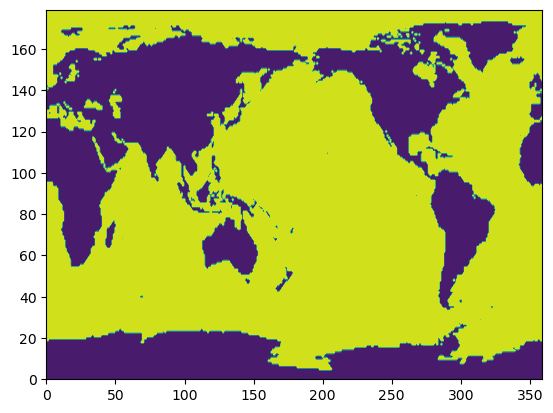

In [47]:
lsm=np.ones((ds_woa09I.sizes['lat'],ds_woa09I.sizes['lon']))
lsm[np.isnan(ds_woa09I['s_an'].isel(time=0,depth=0))] = 0.

plt.contourf(lsm)

In [48]:
ds_WN2['Instab']=xr.where(lsm == 0.,np.nan,ds_WN2['Instab'])

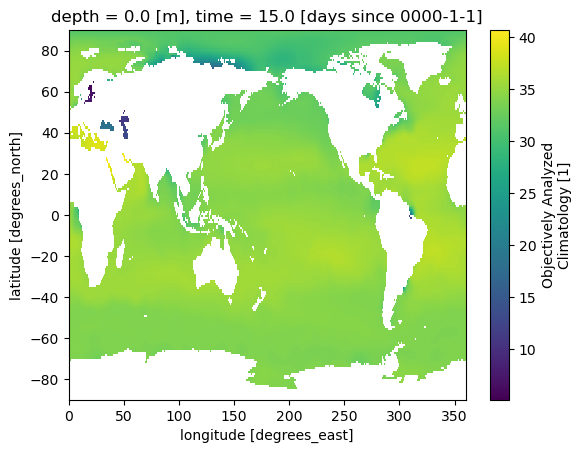

In [32]:
ds_woa09I.s_an.isel(time=0,depth=0).plot()

Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column \n when salinity has been corrected ')

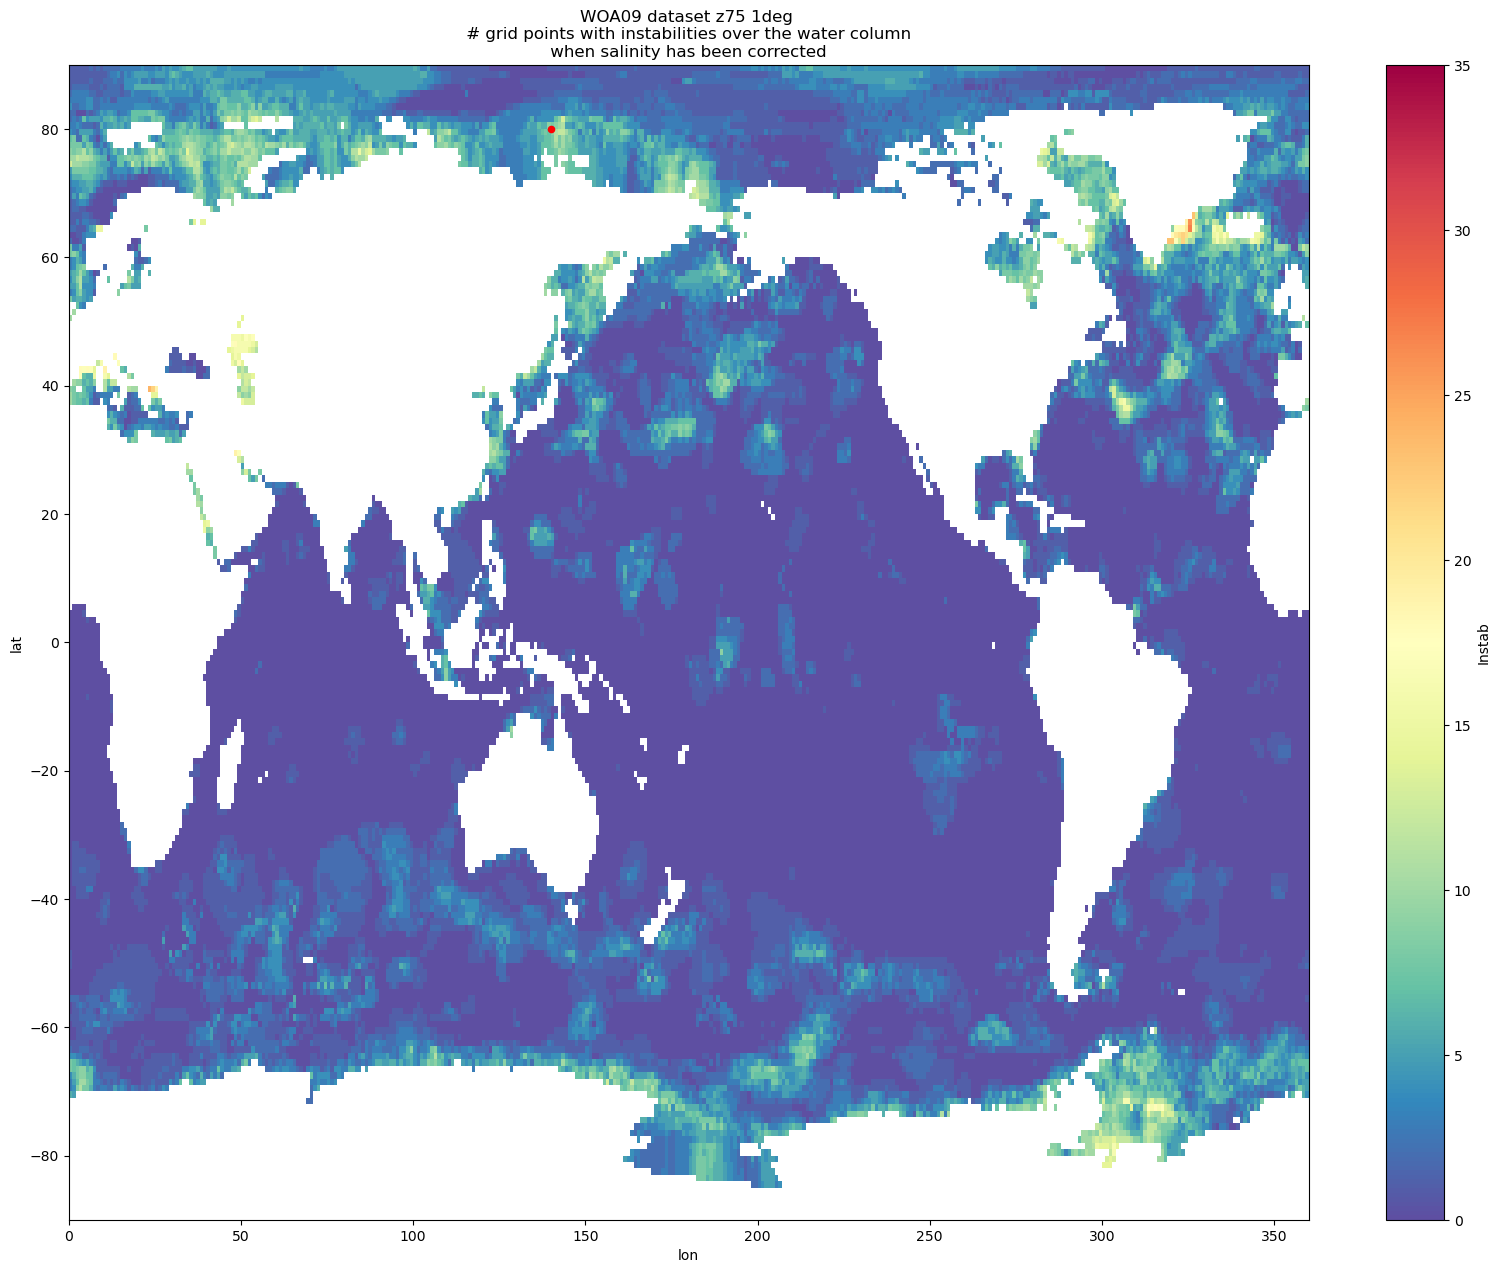

In [51]:
plt.figure(figsize=(20,15))
ds_WN2['Instab'].plot(cmap='Spectral_r',vmax=35,x='lon',y='lat')
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column \n when salinity has been corrected ')

> # Assess the instabilities in the original dataset of WOA09

In [52]:
INDIR="/data0/project/drakkar/CONFIGS/CREG12.L75/CREG12.L75-I/"
ds_Sori=xr.open_mfdataset(INDIR+'woa09_SalAbs_monthly_1deg_SA_CMA_drowned_Ex_L75.nc')
ds_Sori

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>
    lat      (lat0, lon0) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>
    lon      (lat0, lon0) float32 dask.array<chunksize=(180, 360), meta=np.ndarray>

In [53]:
# Append this geo. to the WOA09 dataset 
ds_Sori.coords['lat']=(('lat0','lon0'),lat2D)
ds_Sori.coords['lon']=(('lat0','lon0'),lon2D)
#ds_inS.coords['lon']=(('lat0','lon0'),lon2D-180.)
#ds_inT.coords['lat']=(('lat0','lon0'),lat2D)
#ds_inT.coords['lon']=(('lat0','lon0'),lon2D-180.)

In [54]:
ds_Sori.coords['depth']=(('z'),depth.data)
ds_Sori

<xarray.Dataset>
Dimensions:  (time_counter: 12, z: 75, lat0: 180, lon0: 360)
Coordinates:
    lat      (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon      (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: time_counter, z, lat0, lon0
Data variables:
    SA       (time_counter, z, lat0, lon0) float64 dask.array<chunksize=(12, 75, 180, 360), meta=np.ndarray>

In [56]:
# Compute the Brunt-Vaissalla frequency
DINT_N2,p_imd=gsw.Nsquared(ds_Sori['SA'].isel(time_counter=0).values,\
                            ds_inT['CT'].isel(time_counter=0).values,\
                            pressure,axis=0)

In [57]:
ds_WN2['N2_Sori']=(('depth','lat0','lon0'),DINT_N2)
# Build a 2D map to see how many instabilities occur on each water column
num_DINT_N2=np.where(DINT_N2 < 0.,1.,0.)
# Remove the grid points in the a pseudo ML
num_DINT_N2[0:10,:,:]=0. 
num_DINT_N2[50::,:,:]=0. 
ds_WN2['Instab_Sori']=(('lat0','lon0'),np.sum(num_DINT_N2,axis=0))
ds_WN2['Instab_Sori']=xr.where(lsm == 0.,np.nan,ds_WN2['Instab_Sori'])    

Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column \n ORIGINAL salinity ')

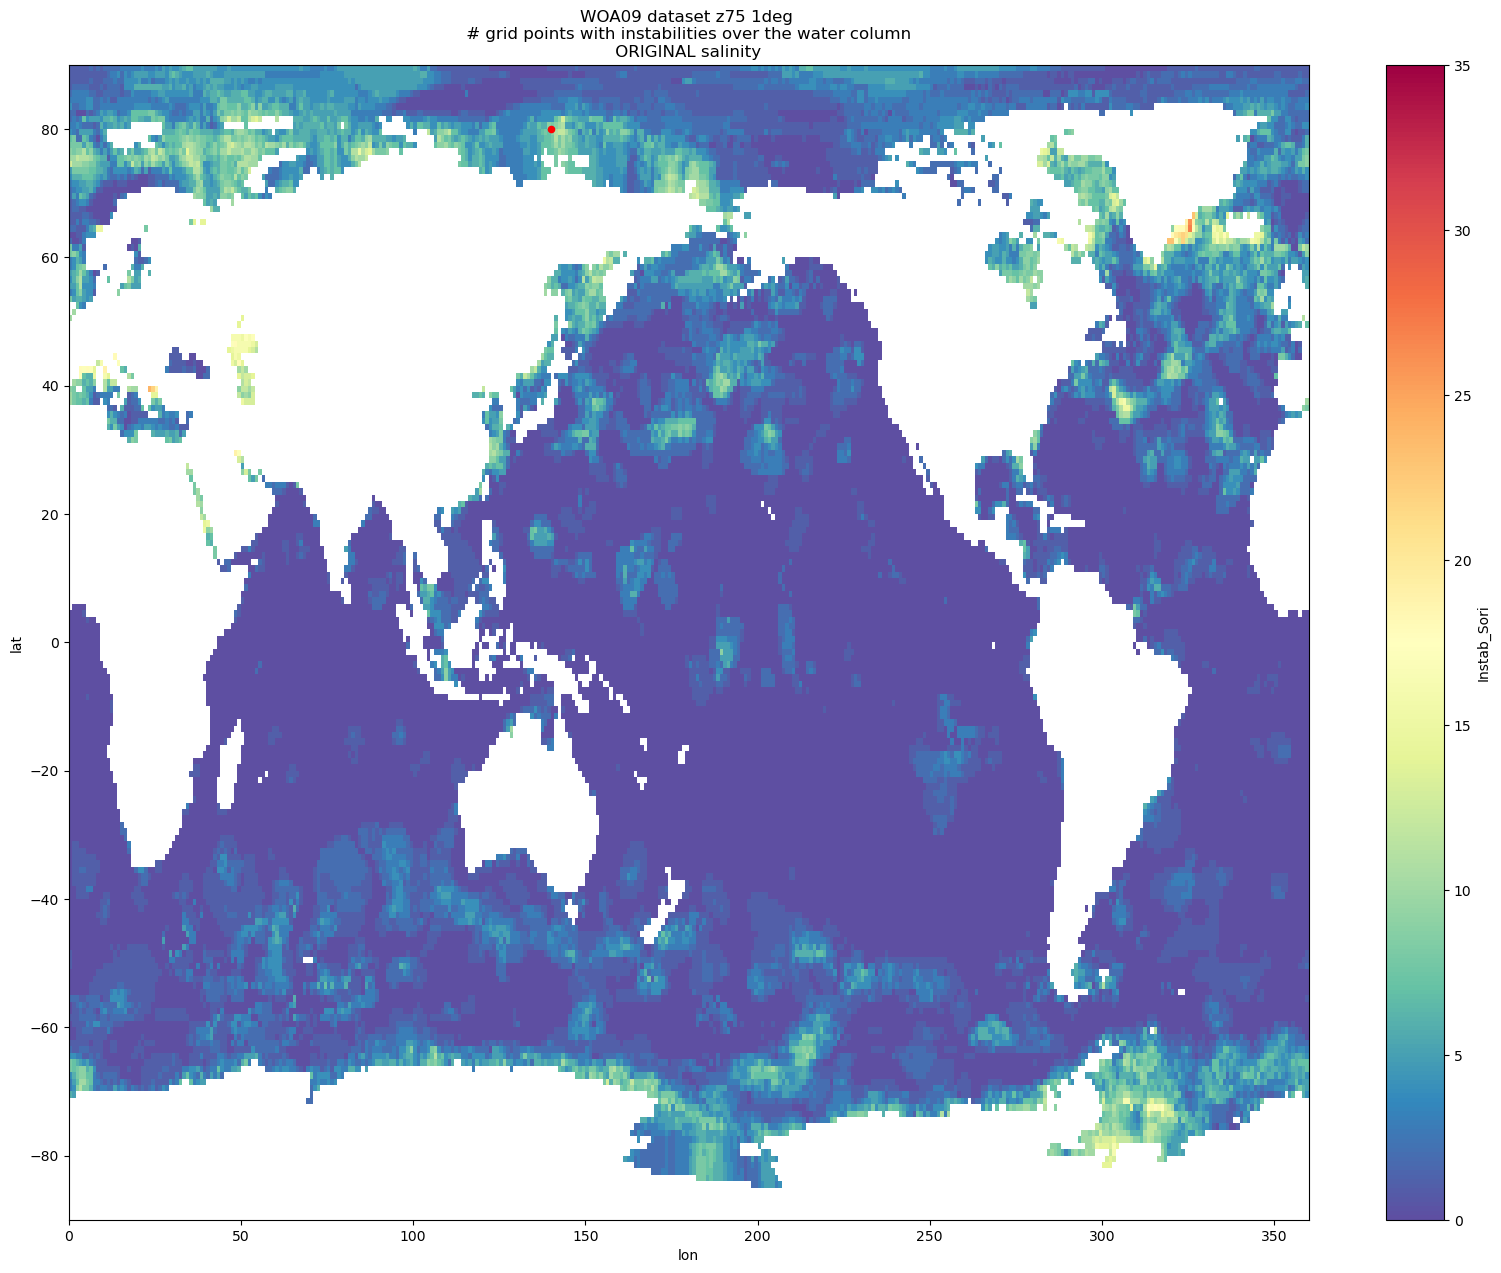

In [58]:
plt.figure(figsize=(20,15))
ds_WN2['Instab_Sori'].plot(cmap='Spectral_r',vmax=35,x='lon',y='lat')
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column \n ORIGINAL salinity ')

Text(0.5, 1.0, 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column \n DIFFERENCES ')

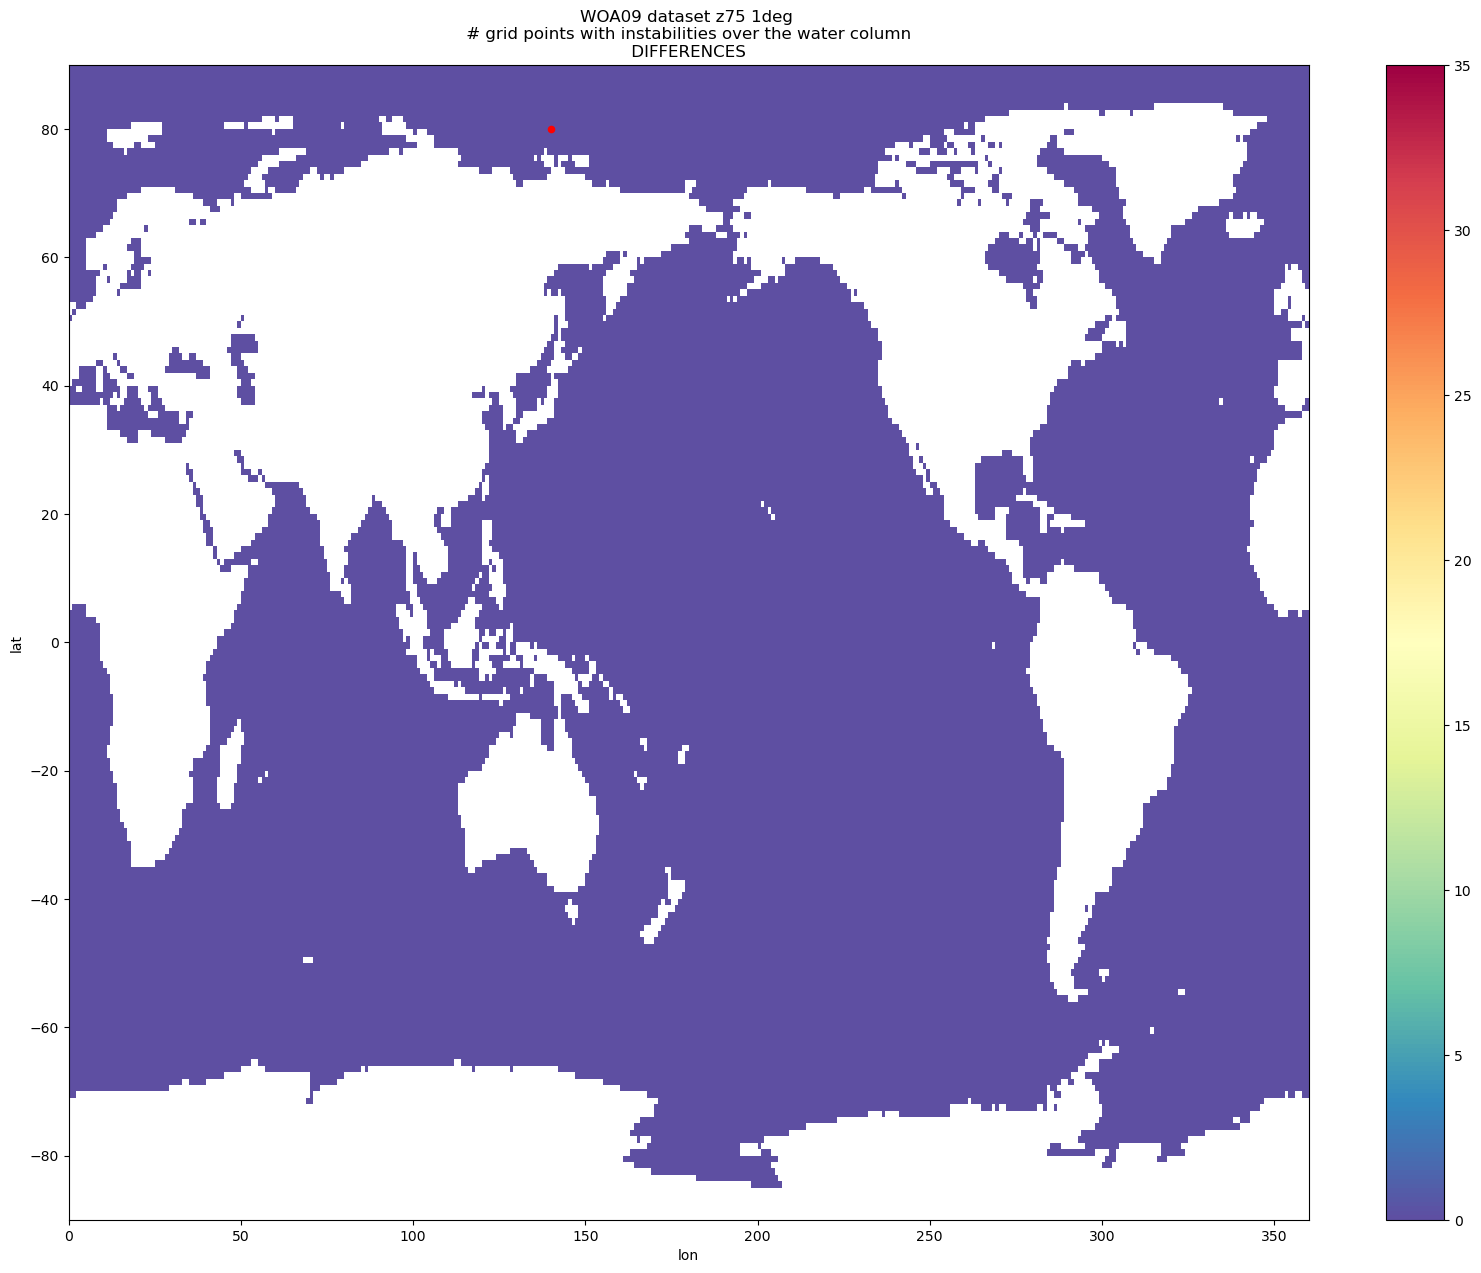

In [59]:
plt.figure(figsize=(20,15))
(ds_WN2['Instab']-ds_WN2['Instab_Sori']).plot(cmap='Spectral_r',vmax=35,x='lon',y='lat')
# Latitude & longitude
loc_x=140  ;  loc_y=80
plt.scatter(loc_x,loc_y,20,marker='o', color='r')
plt.title( 'WOA09 dataset z75 1deg \n # grid points with instabilities over the water column \n DIFFERENCES ')

In [61]:
ds_WN2

<xarray.Dataset>
Dimensions:      (depth: 74, lat0: 180, lon0: 360, z: 75)
Coordinates:
    lat          (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon          (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    depth        (z) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: lat0, lon0, z
Data variables:
    N2           (depth, lat0, lon0) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    Instab       (lat0, lon0) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0
    N2_Sori      (depth, lat0, lon0) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    Instab_Sori  (lat0, lon0) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0

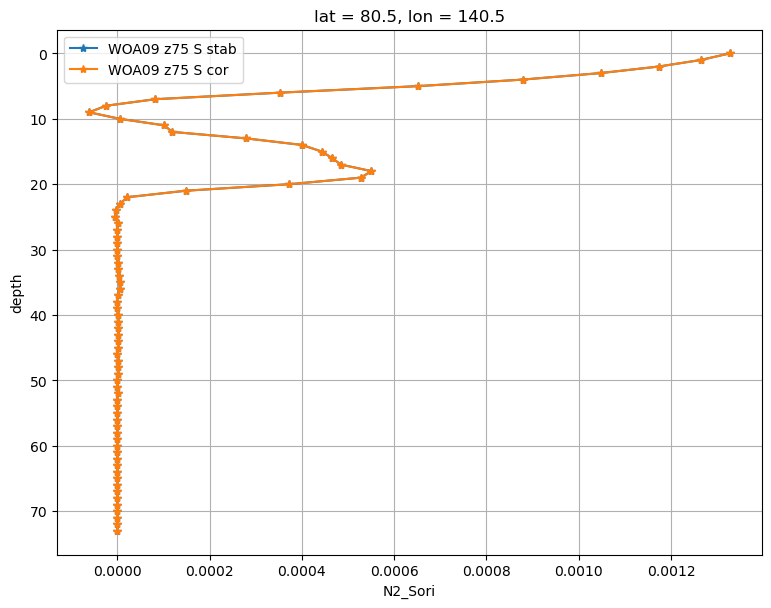

In [76]:
plt.figure(figsize=(20,15))
# Latitude & longitude indexes
loc_x=140  ;  loc_y=170   ;  zdep=300.

plt.subplot(221)
ds_WN2['N2'].isel(lat0=loc_y,lon0=loc_x).plot.line(y='depth',marker='*',label='WOA09 z75 S stab',yincrease=False)
ds_WN2['N2_Sori'].isel(lat0=loc_y,lon0=loc_x).plot.line(y='depth',marker='*',label='WOA09 z75 S cor',yincrease=False)

plt.legend()
#plt.ylim([zdep,0.])
plt.grid(True)


In [74]:
ds_WN2['depth']

<xarray.DataArray 'depth' (z: 75)>
array([5.0576001e-01, 1.5558553e+00, 2.6676817e+00, 3.8562799e+00,
       5.1403613e+00, 6.5430336e+00, 8.0925188e+00, 9.8227501e+00,
       1.1773680e+01, 1.3991038e+01, 1.6525322e+01, 1.9429802e+01,
       2.2757616e+01, 2.6558300e+01, 3.0874561e+01, 3.5740204e+01,
       4.1180023e+01, 4.7211895e+01, 5.3850636e+01, 6.1112839e+01,
       6.9021683e+01, 7.7611160e+01, 8.6929428e+01, 9.7041313e+01,
       1.0803028e+02, 1.2000000e+02, 1.3307582e+02, 1.4740625e+02,
       1.6316446e+02, 1.8054993e+02, 1.9978996e+02, 2.2114117e+02,
       2.4489062e+02, 2.7135638e+02, 3.0088751e+02, 3.3386282e+02,
       3.7068848e+02, 4.1179385e+02, 4.5762561e+02, 5.0863989e+02,
       5.6529230e+02, 6.2802600e+02, 6.9725867e+02, 7.7336829e+02,
       8.5667896e+02, 9.4744788e+02, 1.0458542e+03, 1.1519912e+03,
       1.2658615e+03, 1.3873770e+03, 1.5163636e+03, 1.6525685e+03,
       1.7956708e+03, 1.9452955e+03, 2.1010266e+03, 2.2624216e+03,
       2.4290251e+03, 2.6003804e+03, 2.7760393e+03, 2.9555703e+03,
       3.1385649e+03, 3.3246409e+03, 3.5134456e+03, 3.7046567e+03,
       3.8979819e+03, 4.0931587e+03, 4.2899526e+03, 4.4881548e+03,
       4.6875811e+03, 4.8880698e+03, 5.0894785e+03, 5.2916831e+03,
       5.4945752e+03, 5.6980605e+03, 5.9020576e+03], dtype=float32)
Coordinates:
    depth    (z) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03 5.902e+03
Dimensions without coordinates: z

In [60]:
ds_WN2

<xarray.Dataset>
Dimensions:      (depth: 74, lat0: 180, lon0: 360, z: 75)
Coordinates:
    lat          (lat0, lon0) float32 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5
    lon          (lat0, lon0) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
    depth        (z) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
Dimensions without coordinates: lat0, lon0, z
Data variables:
    N2           (depth, lat0, lon0) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    Instab       (lat0, lon0) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0
    N2_Sori      (depth, lat0, lon0) float64 nan nan nan nan ... 0.0 0.0 0.0 0.0
    Instab_Sori  (lat0, lon0) float64 nan nan nan nan nan ... 1.0 1.0 1.0 1.0

# Output new fields 

In [29]:
if False:
    INDIR="./CREG12.L75-I/"
    ds_out=xr.Dataset()
    # Save WOA09 Practical Salinity 
    ds_out['s_an']=(('time_counter','z','lat0','lon0'),ds_SP.values)
    #ds_out['lat']=(('lat0','lon0'),ds_inS['lat'].values)
    #ds_out['lon']=(('lat0','lon0'),ds_inS['lon'].values)
    ds_out.attrs['History']='This salinity field has been stabilise using GSW gsw_stabilise_SA_const_t function, i.e. without changing the temperature'
    #ds_out.to_netcdf(INDIR+'woa09_salinity_monthly_1deg_s_an_CMA_drowned_Ex_L75_stabilise.nc',unlimited_dims='time_counter')
    ds_out.to_netcdf(INDIR+'stabilise.nc',unlimited_dims='time_counter')